In [22]:
import sys
sys.path.append('../')
import argparse
import os
# https_proxy
os.environ['https_proxy'] = 'http://localhost:7890'
# cuda visible devices
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import torch.nn as nn

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    pipeline,
)

from trl import SFTTrainer

# from transformers import LlamaTokenizer, LlamaForCausalLM
from peft import PeftModel, LoraConfig, TaskType, get_peft_model
from datasets import load_dataset

from evaluate import evaluate_model
from modules.svd_lora_linear import SVDLoRALinear
from modules.act_aware_svd_lora_linear import ActAwareSVDLoRALinear
from utils import print_gpu_memory
from datautils import get_calib_data
import json
from tqdm import tqdm
from experiments.single_block_sensitivity import calib_input_distribution
import copy
import matplotlib.pyplot as plt


In [2]:
def convert_linear_to_svd_lora_linear(module,sensitivity_json,ppl_thresh,filter_layer_name):
    # load json
    layer_sensitivities = {}
    all_ppls = []
    with open(sensitivity_json) as f:
        for l in f.readlines():
            # format {'wikitext2': 35.48416519165039, 'mean': 0.52, 'rank_ratio': 0.1, 'full_name': 'model.decoder.layers.11.fc1'},
            d = eval(l)[0]
            layer_name = d["full_name"]
            wiki_ppl = d["wikitext2"]
            rank_ratio = d["rank_ratio"]
            all_ppls.append(wiki_ppl)
            if layer_name not in layer_sensitivities:
                layer_sensitivities[layer_name] = {1: -1}
            layer_sensitivities[layer_name][rank_ratio] = wiki_ppl
    ppl_thresh = ppl_thresh
    layer_ratio_settings = {}
    for layer_name, layer_data in layer_sensitivities.items():
        ratios = []
        for rank_ratio, ppl in layer_data.items():
            if ppl < ppl_thresh:
                ratios.append(rank_ratio)
        ratio = min(ratios)
        layer_ratio_settings[layer_name] = ratio

    full_name_dict = {module: name for name, module in module.named_modules()}
    modules = [module]
    while len(modules) > 0:
        submodule = modules.pop()
        for name, child in submodule.named_children():
            if isinstance(child, nn.Linear):
                full_name = full_name_dict[child]
                if filter_layer_name not in full_name:
                    continue
                rank_ratio = layer_ratio_settings[full_name]
                if rank_ratio == 1:
                    print(f"skip {full_name} to svd_lora_linear ratio={rank_ratio}")
                    continue
                svd_linear = SVDLoRALinear.from_linear(
                    child,
                    r_ratio=rank_ratio,
                    lora_method='reconstruct',
                    act_aware=True,
                )
                del child.weight
                setattr(submodule, name, svd_linear)
                print(f"convert {full_name} to svd_lora_linear ratio={rank_ratio}")
            else:
                modules.append(child)


In [31]:
model_id = "facebook/opt-125m"
sensitivity_json = "../output/sensitivity_facebook_opt-125m_True.json"
ppl_thresh = 28



# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"  # Fix for fp16

model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto")
model.config.use_cache = False
model.config.pretraining_tp = 1
cablib_dataset = "wikitext2"
calib_loader = get_calib_data(cablib_dataset, tokenizer, model_id, 256)
calib_input_distribution(model, calib_loader)

model = model.to_bettertransformer()




The BetterTransformer implementation does not support padding during training, as the fused kernels do not support attention masks. Beware that passing padded batched data during training may result in unexpected outputs. Please refer to https://huggingface.co/docs/optimum/bettertransformer/overview for more details.


 get_ptq_calib_data wikitext2, nsamples=256, seqlen=2048, 3


skip model.decoder.layers.5.fc1 to svd_lora_linear ratio=1
convert model.decoder.layers.5.fc2 to svd_lora_linear ratio=0.4
convert model.decoder.layers.5.self_attn.k_proj to svd_lora_linear ratio=0.2
convert model.decoder.layers.5.self_attn.v_proj to svd_lora_linear ratio=0.3
convert model.decoder.layers.5.self_attn.q_proj to svd_lora_linear ratio=0.2
convert model.decoder.layers.5.self_attn.out_proj to svd_lora_linear ratio=0.3
mean relative diff=3.8147265911102295
skip model.decoder.layers.5.fc1 to svd_lora_linear ratio=1
mean relative diff=0.0
convert model.decoder.layers.5.fc2 to svd_lora_linear ratio=0.4
mean relative diff=4.086459636688232
convert model.decoder.layers.5.self_attn.k_proj to svd_lora_linear ratio=0.2
mean relative diff=0.5565254092216492
convert model.decoder.layers.5.self_attn.v_proj to svd_lora_linear ratio=0.3
mean relative diff=0.8031617999076843
convert model.decoder.layers.5.self_attn.q_proj to svd_lora_linear ratio=0.2
mean relative diff=0.5552641749382019
c

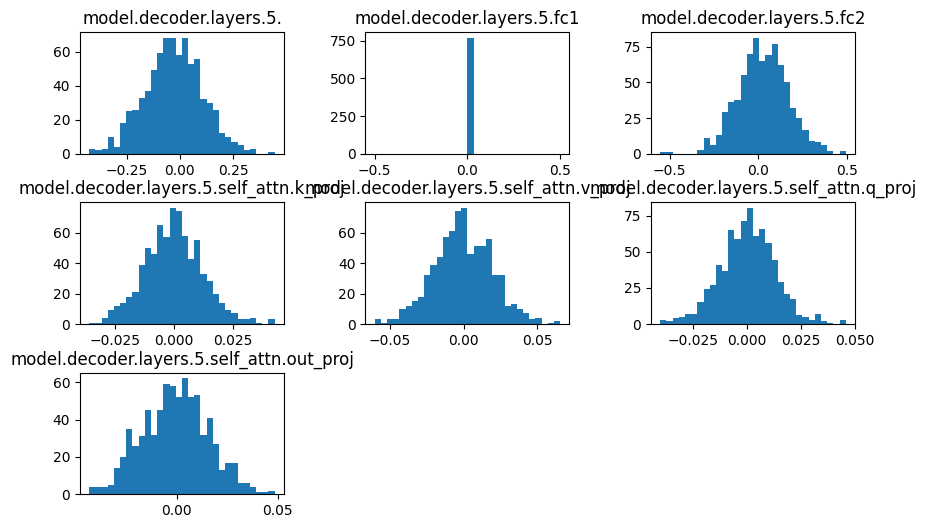

In [41]:
layer_output=[]
def hook(m,i,o):
    layer_output.append(o)

filter_layer_names = ["model.decoder.layers.5.",
                      "model.decoder.layers.5.fc1",
                      "model.decoder.layers.5.fc2",
                      "model.decoder.layers.5.self_attn.k_proj",
                    "model.decoder.layers.5.self_attn.v_proj",
                    "model.decoder.layers.5.self_attn.q_proj",
                    "model.decoder.layers.5.self_attn.out_proj",
                      ]

# plot the diff hist in one picture
figure=plt.figure(figsize=(10, 6))
figure.subplots_adjust(hspace=0.4, wspace=0.4)



for filter_layer_name in filter_layer_names:
    model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto")
    calib_input_distribution(model, model_id, calib_loader)

    model.model.decoder.layers[5].register_forward_hook(hook)

    query = "### Human: I am depressed, what should I do?"
    text_gen = pipeline(
        task="text-generation",
        model=model,
        tokenizer=tokenizer,
        max_length=200,
    )
    # output = text_gen(f"<s>[INST] {query} [/INST]")
    output = text_gen(query)
    raw_layer_output = layer_output[-1][0].detach()
    convert_linear_to_svd_lora_linear(model ,sensitivity_json,ppl_thresh,filter_layer_name)
    output = text_gen(query)
    diff=layer_output[-1][0]-raw_layer_output
    # calculate mean relative diff
    mean_diff = torch.mean(torch.abs(diff) / torch.abs(raw_layer_output))
    print(f"mean relative diff={mean_diff}")
    # plt.hist(diff.cpu().numpy().flatten(), bins=100)
    # plt.title(filter_layer_name)
    # plt.show()
    figure.add_subplot(3, 3, filter_layer_names.index(filter_layer_name)+1)
    plt.hist(diff.cpu().numpy().flatten(), bins=30)
    plt.title(filter_layer_name)

    layer_output.clear()

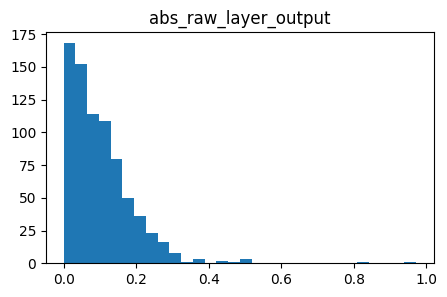

In [40]:
abs_raw=raw_layer_output.abs()
# plot abs_raw hist in new figure
figure=plt.figure(figsize=(5, 3))
plt.hist(abs_raw.cpu().numpy().flatten(), bins=30)
plt.title("abs_raw_layer_output")
plt.show()


In [45]:
model.model.decoder.layers[5]

OPTDecoderLayer(
  (self_attn): OPTAttention(
    (k_proj): Linear(in_features=768, out_features=768, bias=True)
    (v_proj): Linear(in_features=768, out_features=768, bias=True)
    (q_proj): Linear(in_features=768, out_features=768, bias=True)
    (out_proj): Linear(in_features=768, out_features=768, bias=True)
  )
  (activation_fn): ReLU()
  (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=768, out_features=3072, bias=True)
  (fc2): Linear(in_features=3072, out_features=768, bias=True)
  (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)